# Performance of NPB-C++



In [ ]:
%pip install --upgrade plotly numpy nbformat kaleido pandas

In [9]:
import pandas as pd
import glob
from pathlib import Path
import plotly.express as px
from IPython.display import display, Image


results_dir = Path("run-SER").resolve()
print(f"Results directory: {results_dir}")

Results directory: /home/yohan/Work/fuzzy-pytorch/experiments/NPB/run-SER


## Parse results

In [ ]:
# Load the results from text files


def load_results(directory, tool, bench, size):
    pattern = directory / f"{tool}_{bench}_{size}_results" / "**" / "stdout"
    files = glob.glob(str(pattern.resolve()), recursive=True)
    values = {}
    for file in files:
        repetition = file.split("/")[-2]
        with open(file, "r") as f:
            for line in f:
                if "Time in seconds =" in line:
                    time_str = line.split("=")[1].strip()
                    values["Time"] = values.get("Time", []) + [float(time_str)]
                elif "Mop/s total" in line:
                    mop_str = line.split("=")[1].strip()
                    values["Mops"] = values.get("Mops", []) + [float(mop_str)]
            values["Tool"] = tool
            values["Bench"] = bench
            values["Class"] = size
            values["Repetition"] = values.get("Repetition", []) + [repetition]
    return pd.DataFrame(values)

In [83]:
bench = ["BT", "CG", "EP", "FT", "LU", "MG", "SP"]
size = ["S", "A"]
tools = [
    "cadna",
    "ieee",
    "prism_sr_dynamic",
    "prism_sr_static",
    "prism_ud_static",
    "prism_ud_dynamic",
    "sr",
    "verificarlo",
    "verrou_cestac",
    "verrou_sr",
]

results = pd.DataFrame()
for b in bench:
    for s in size:
        for t in tools:
            df = load_results(directory=results_dir, tool=t, bench=b.lower(), size=s)
            results = pd.concat([results, df], ignore_index=True)

results["Variant"] = results["Tool"].str.split("_").str[1]
results

,Time,Mops,Tool,Bench,Class,Repetition,Variant
0,4.58,49.95,cadna,bt,S,3,NaN
1,4.58,49.90,cadna,bt,S,2,NaN
2,4.56,50.11,cadna,bt,S,1,NaN
3,0.09,2523.84,ieee,bt,S,1,NaN
4,0.06,3574.66,ieee,bt,S,2,NaN
...,...,...,...,...,...,...,...
415,1255.27,67.72,verrou_cestac,sp,A,2,cestac
416,1256.08,67.68,verrou_cestac,sp,A,3,cestac
417,1510.41,56.28,verrou_sr,sp,A,2,sr
418,1501.75,56.61,verrou_sr,sp,A,1,sr


## Compute statistics

In [ ]:
# Compute the reference (ieee) time for each repetition, bench, and class
ieee_times = results[results["Tool"] == "ieee"][
    ["Bench", "Class", "Repetition", "Time"]
].rename(columns={"Time": "Time_ieee"})

# Merge ieee times into the results DataFrame
results = results.merge(ieee_times, on=["Bench", "Class", "Repetition"], how="left")

# Compute slowdown
results["Time_slowdown"] = results["Time"] / results["Time_ieee"]

results_stats = (
    results.groupby(["Tool", "Bench", "Class"])
    .agg(
        {
            "Time": ["mean", "std"],
            "Mops": ["mean", "std"],
            "Time_slowdown": ["mean", "std"],
        }
    )
    .reset_index()
)
# Flatten MultiIndex columns
results_stats.columns = [
    "_".join(filter(None, col)).strip("_") for col in results_stats.columns.values
]
# Merge the Variant columns into a single 'Variant' column
results_stats["Variant"] = results_stats["Tool"].str.split("_").str[1]
results_stats["Variant"] = results_stats["Variant"].fillna("")
results_stats.to_csv("perf-NPB-SER-stats.csv", index=False)

,Tool,Bench,Class,Time_mean,Time_std,Mops_mean,Mops_std,Time_slowdown_mean,Time_slowdown_std,Variant
0,cadna,bt,A,2821.753333,8.226763,59.643333,0.175024,58.592301,0.338965,
1,cadna,bt,S,4.573333,0.011547,49.986667,0.109697,64.142857,12.881547,
2,cadna,cg,A,19.946667,2.079816,75.590000,8.029190,16.630798,1.838025,
3,cadna,cg,S,0.753333,0.020817,88.990000,2.620897,18.833333,0.520416,
4,cadna,ep,A,28.943333,0.040415,18.553333,0.025166,1.737993,0.003817,
...,...,...,...,...,...,...,...,...,...,...
135,verrou_sr,lu,S,2.390000,0.034641,42.806667,0.672780,73.083333,12.021682,sr
136,verrou_sr,mg,A,83.146667,0.101160,46.813333,0.057735,84.564129,1.051021,sr
137,verrou_sr,mg,S,0.173333,0.005774,44.023333,1.648707,28.888889,0.962250,sr
138,verrou_sr,sp,A,1508.490000,6.014416,56.353333,0.228983,61.306249,0.567444,sr


## Figure

In [4]:
colors_map = {
    "IEEE": "#a80ca8",
    "Verrou": "#ff7f0e",
    "PRISM": "#1f77b4",
    "CESTAC": "#1fb438",
    "FM SR": "#26b7e4",
    "MCA RR": "#f10202",
}

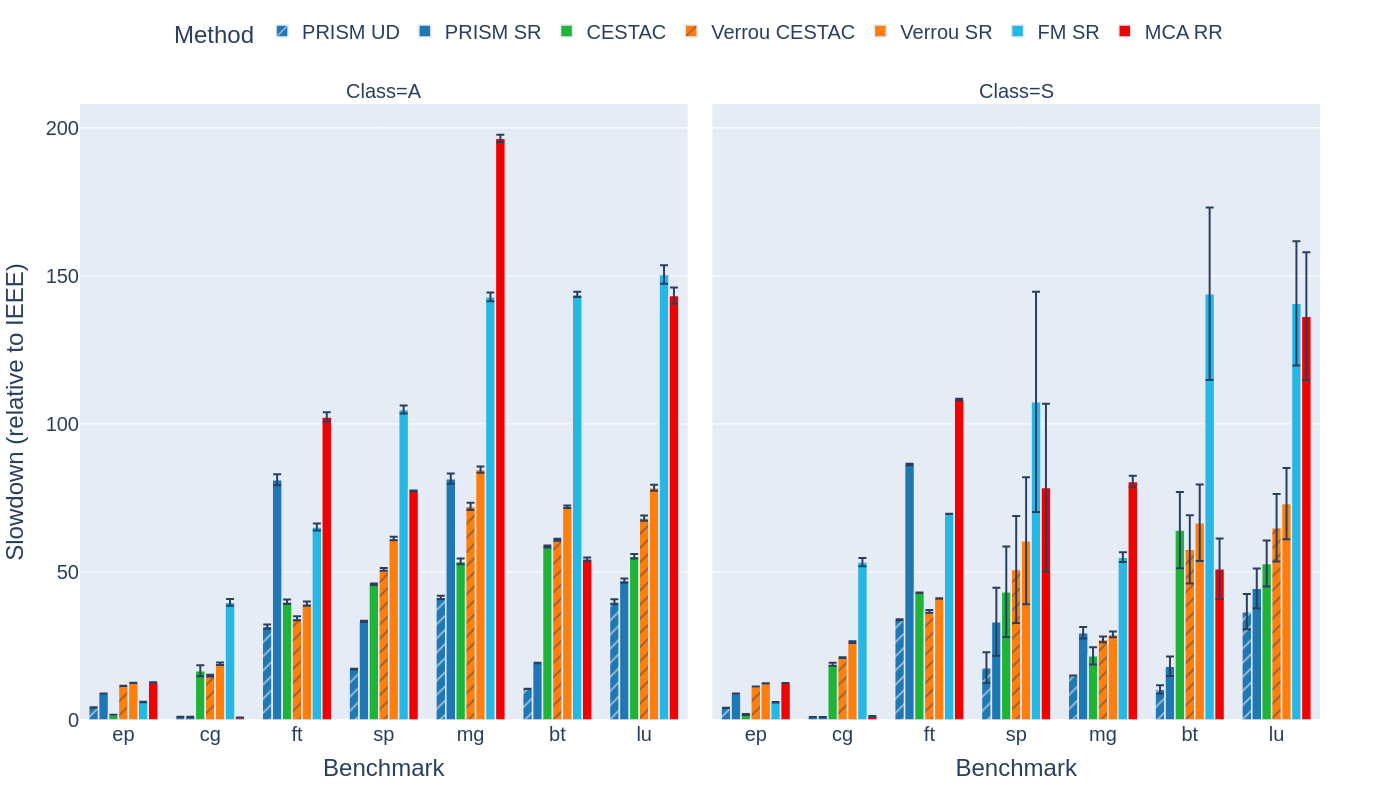

In [15]:
results_stats = pd.read_csv("perf-NPB-SER-stats.csv")
results_stats.fillna("", inplace=True)
results_stats = results_stats[
    ~results_stats["Tool"].isin(["ieee", "prism_sr_dynamic", "prism_ud_dynamic"])
]
colors_discrete_map = {
    "cadna": colors_map["CESTAC"],
    "ieee": colors_map["IEEE"],
    "prism_sr_static": colors_map["PRISM"],
    "prism_ud_static": colors_map["PRISM"],
    "sr": colors_map["FM SR"],
    "verificarlo": colors_map["MCA RR"],
    "verrou_cestac": colors_map["Verrou"],
    "verrou_sr": colors_map["Verrou"],
}
fig = px.bar(
    results_stats,
    x="Bench",
    y="Time_slowdown_mean",
    error_y="Time_slowdown_std",
    color="Tool",
    barmode="group",
    color_discrete_map=colors_discrete_map,
    pattern_shape="Variant",
    pattern_shape_sequence=["", "", "/", "/", "/", "/", "/", "/", "/"],
    facet_col="Class",
    title="",
    labels={"Time": "Time in seconds", "Bench": "Benchmark"},
    height=600,
    category_orders={
        "Tool": [
            "prism_ud_static",
            "prism_sr_static",
            "cadna",
            "verrou_cestac",
            "verrou_sr",
            "sr",
            "verificarlo",
        ]
    },
)
fig.update_traces(selector=dict(type="bar"), marker_line_width=1.5)
fig.update_layout(
    legend_orientation="h",
    legend_yanchor="top",
    legend_y=1.15,
    legend_xanchor="center",
    legend_x=0.5,
    legend_title_text="Method",
    xaxis_categoryorder="array",
    xaxis_categoryarray=["ep", "cg", "ft", "sp", "mg", "bt", "lu"],
    xaxis2_categoryorder="array",
    xaxis2_categoryarray=["ep", "cg", "ft", "sp", "mg", "bt", "lu"],
    legend_traceorder="normal",
    font_size=20,
    font_family="Helvetica, sans-serif",
)
# Set custom legend/group order
custom_order = [
    "prism_ud_static, ud",
    "prism_sr_static, sr",
    "cadna, ",
    "sr, ",
    "verrou_cestac, cestac",
    "verrou_sr, sr",
    "verificarlo, ",
]
# Update legend names for clarity
legend_rename = {
    "prism_sr_static, sr": "PRISM SR",
    "cadna, ": "CESTAC",
    "verrou_sr, sr": "Verrou SR",
    "verificarlo, ": "MCA RR",
    "prism_ud_static, ud": "PRISM UD",
    "verrou_cestac, cestac": "Verrou CESTAC",
    "sr, ": "FM SR",
}
legend_group = {
    "prism_sr_static, sr": "PRISM",
    "cadna, ": "CESTAC",
    "verrou_sr, sr": "Verrou",
    "verificarlo, ": "MCA RR",
    "prism_ud_static, ud": "PRISM",
    "verrou_cestac, cestac": "Verrou",
    "sr, ": "FM SR",
}

for i, name in enumerate(custom_order):
    for trace in fig.data:
        if trace.name in legend_rename:
            trace.legendgroup = legend_group[trace.name]
            trace.name = legend_rename[trace.name]
for i, name in enumerate(custom_order):
    for trace in fig.data:
        if trace.name == name:
            trace.legendrank = i

fig.update_yaxes(exponentformat="power", title="Slowdown (relative to IEEE)", col=1)

display(Image(fig.to_image(width=1400, height=800)))
fig.show()